In [115]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
    
import pandas as pd             
import seaborn as sns           
import sklearn  

# HR Analysis Study

В данной работе на основе данных сотрудников компании решается задача бинарной классификации: необходимо предсказать продвинется человек по карьерной лестнице или же останется на текущей должности. 

Датасет включает в себя около 55000 записей, а также 14 признаков:

1\. employee_id - уникальный идентификатор сотрудника;

2\. department - отдел, к которому прикреплен сотрудник;

3\. region - регион;

4\. education - образование сотрудника;

5\. gender - пол;

6\. recruitment_channel - канал подбора персонала;

7\. no_of_trainings - число пройденных тренингов;

8\. age - возраст;

9\. previous_year_rating - рейтинг сотрудника за предыдущий год по пятибалльной шкале;

10\. length_of_service - стаж;

11\. KPIs_met>80% - показатель эффективности, принимает значения 0(< 80%) и 1(> 80%);

12\. awards_won - наличие влзнаграждений(0 - нет, 1 - есть);

13\. avg_training_score - средний балл за пройденные тренинги;

14\. is_promoted - принимает два значения: 0 - сотрудник не продвинется по службе, 1 - продвинется.

## Загрузка и чтение данных

In [116]:
url = "train.csv"
data_raw = pd.read_csv(url)

Выведем размер таблицы, а также 5 первых и последних строк таблицы

In [117]:
data_raw.shape

(54808, 14)

In [118]:
data_raw.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [119]:
data_raw.tail()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0
54807,51526,HR,region_22,Bachelor's,m,other,1,27,1.0,5,0,0,49,0


Таблица содержит 5 категориальных признаков и 9 числовых признаков. Целевой признак - колонка is_promoted. 

In [120]:
categorical_columns = [c for c in data_raw.columns if data_raw[c].dtype.name == 'object']
numerical_columns   = [c for c in data_raw.columns if data_raw[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['department', 'region', 'education', 'gender', 'recruitment_channel']
['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted']


In [121]:
data_raw = data_raw.drop(['employee_id'], axis = 1)
numerical_columns.remove('employee_id')

Выведем значения, которые принимают категориальные признаки. Видно, что признак "образование" содержит пропущенные значения, которые необходимо обработать.  

In [122]:
data_raw['department'].unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

In [123]:
data_raw['region'].unique()

array(['region_7', 'region_22', 'region_19', 'region_23', 'region_26',
       'region_2', 'region_20', 'region_34', 'region_1', 'region_4',
       'region_29', 'region_31', 'region_15', 'region_14', 'region_11',
       'region_5', 'region_28', 'region_17', 'region_13', 'region_16',
       'region_25', 'region_10', 'region_27', 'region_30', 'region_12',
       'region_21', 'region_8', 'region_32', 'region_6', 'region_33',
       'region_24', 'region_3', 'region_9', 'region_18'], dtype=object)

In [124]:
data_raw['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [125]:
data_raw['gender'].unique()

array(['f', 'm'], dtype=object)

In [126]:
data_raw['recruitment_channel'].unique()

array(['sourcing', 'other', 'referred'], dtype=object)

## Обработка категориальных признаков

Заменим тип Object на тип, предназначенный для хранения категориальных значений(векторизация проводится позже)

In [127]:
for i in data_raw.columns:
    if data_raw[i].dtype.name == 'object':
        data_raw[i] = data_raw[i].astype('category')
categorical_columns = [i for i in data_raw.columns if data_raw[i].dtype.name == 'category']
categorical_columns

['department', 'region', 'education', 'gender', 'recruitment_channel']

## Визуализация данных

Ниже приведены средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей для числовых признаков. 

In [128]:
data_raw.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [129]:
data_raw.describe(include=['category'])

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


Из двух таблиц выше видим, что, например, в компании работают сотрудники от 20 до 60 лет, преимущественно мужчины, средний стаж сотрудников около 6 лет. БОльшая часть сотрудников имеет образование бакалавра и работает в отделе маркетинга. 

Посмотрим, сколько раз категориальные признаки принимают то или иное значение.

In [130]:
data_raw['department'].value_counts()

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

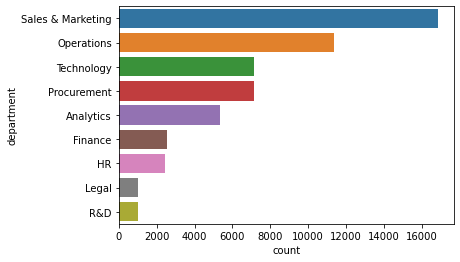

In [131]:
sns.countplot(y='department',order=data_raw['department'].value_counts().index, data=data_raw)
pass

In [132]:
data_raw['region'].value_counts()

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

In [133]:
data_raw['education'].value_counts()


Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

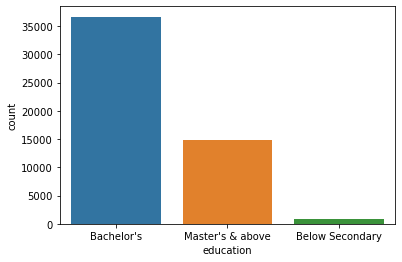

In [134]:
sns.countplot(x='education',order=data_raw['education'].value_counts().index, data=data_raw)
pass

In [135]:
data_raw['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

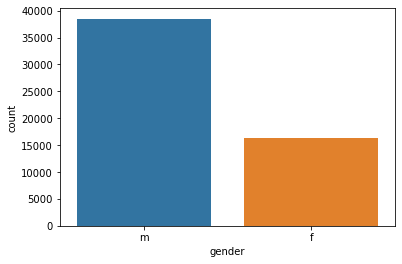

In [136]:
sns.countplot(x='gender',order=data_raw['gender'].value_counts().index, data=data_raw)
pass

In [137]:
data_raw['recruitment_channel'].value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

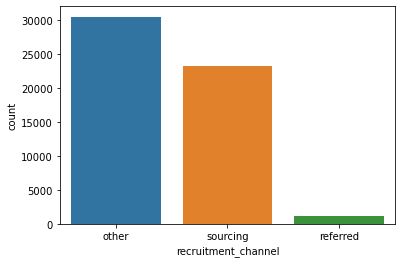

In [138]:
sns.countplot(x='recruitment_channel',order=data_raw['recruitment_channel'].value_counts().index, data=data_raw)
pass

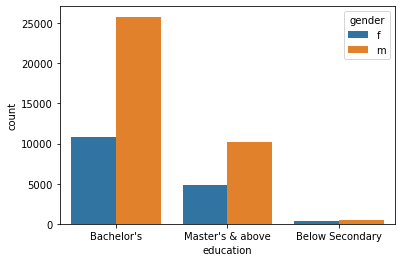

In [139]:
sns.countplot(x='education', order=data_raw['education'].value_counts().index, hue='gender', data=data_raw)
pass

Корреляционная матрица отражает степень связи между признаками:

In [140]:
corr_mat = data_raw.corr()
corr_mat

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.081278,-0.063126,-0.057275,-0.045576,-0.007628,0.042517,-0.024896
age,-0.081278,1.000000,0.006008,0.657111,-0.025592,-0.008169,-0.048380,-0.017166
previous_year_rating,-0.063126,0.006008,1.000000,0.000253,0.351578,0.027738,0.075139,0.159320
length_of_service,-0.057275,0.657111,0.000253,1.000000,-0.077693,-0.039927,-0.038122,-0.010670
KPIs_met >80%,-0.045576,-0.025592,0.351578,-0.077693,1.000000,0.097000,0.078391,0.221582
awards_won?,-0.007628,-0.008169,0.027738,-0.039927,0.097000,1.000000,0.072138,0.195871
avg_training_score,0.042517,-0.048380,0.075139,-0.038122,0.078391,0.072138,1.000000,0.181147
is_promoted,-0.024896,-0.017166,0.159320,-0.010670,0.221582,0.195871,0.181147,1.000000


Матрица корреляции в графическом виде:

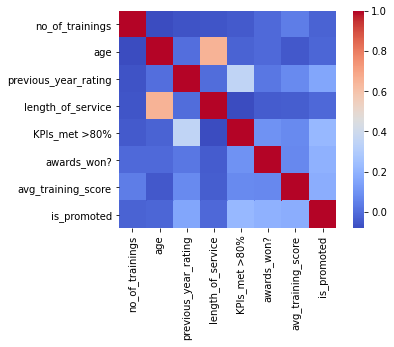

In [141]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Выведем коэффициенты корреляции больше порогового значения 0,5:

In [142]:
corr_mat > 0.5

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
no_of_trainings,True,False,False,False,False,False,False,False
age,False,True,False,True,False,False,False,False
previous_year_rating,False,False,True,False,False,False,False,False
length_of_service,False,True,False,True,False,False,False,False
KPIs_met >80%,False,False,False,False,True,False,False,False
awards_won?,False,False,False,False,False,True,False,False
avg_training_score,False,False,False,False,False,False,True,False
is_promoted,False,False,False,False,False,False,False,True


In [143]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

age  length_of_service    0.657111
dtype: float64

Видно, что есть только одна пара признаков, для которой коэффициент корреляции > 0.5 - возраст и стаж. Остальные пары признаков имеют коэффициент корреляции < 0.5. Наибольший коэффициент корреляции целевой признак is_promoted имеет с признаком, выражающим продуктивность сотрудника - kpi_>80%.
Вывод: нет сильно коррелированных признаков, не требуется убирать признаки(чтобы избежать переобучения).

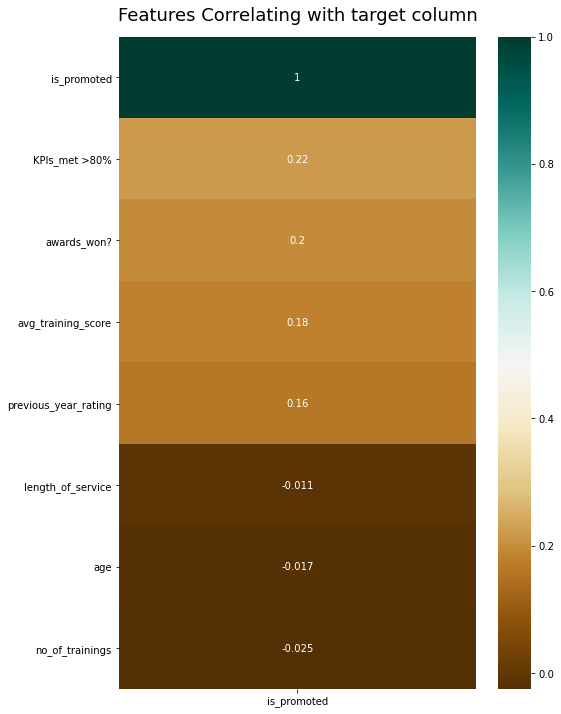

In [144]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data_raw.corr()[['is_promoted']].sort_values(by='is_promoted', ascending=False),annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with target column', fontdict={'fontsize':18}, pad=16);

Построим диаграммы рассеивания для каждой пары признаков:

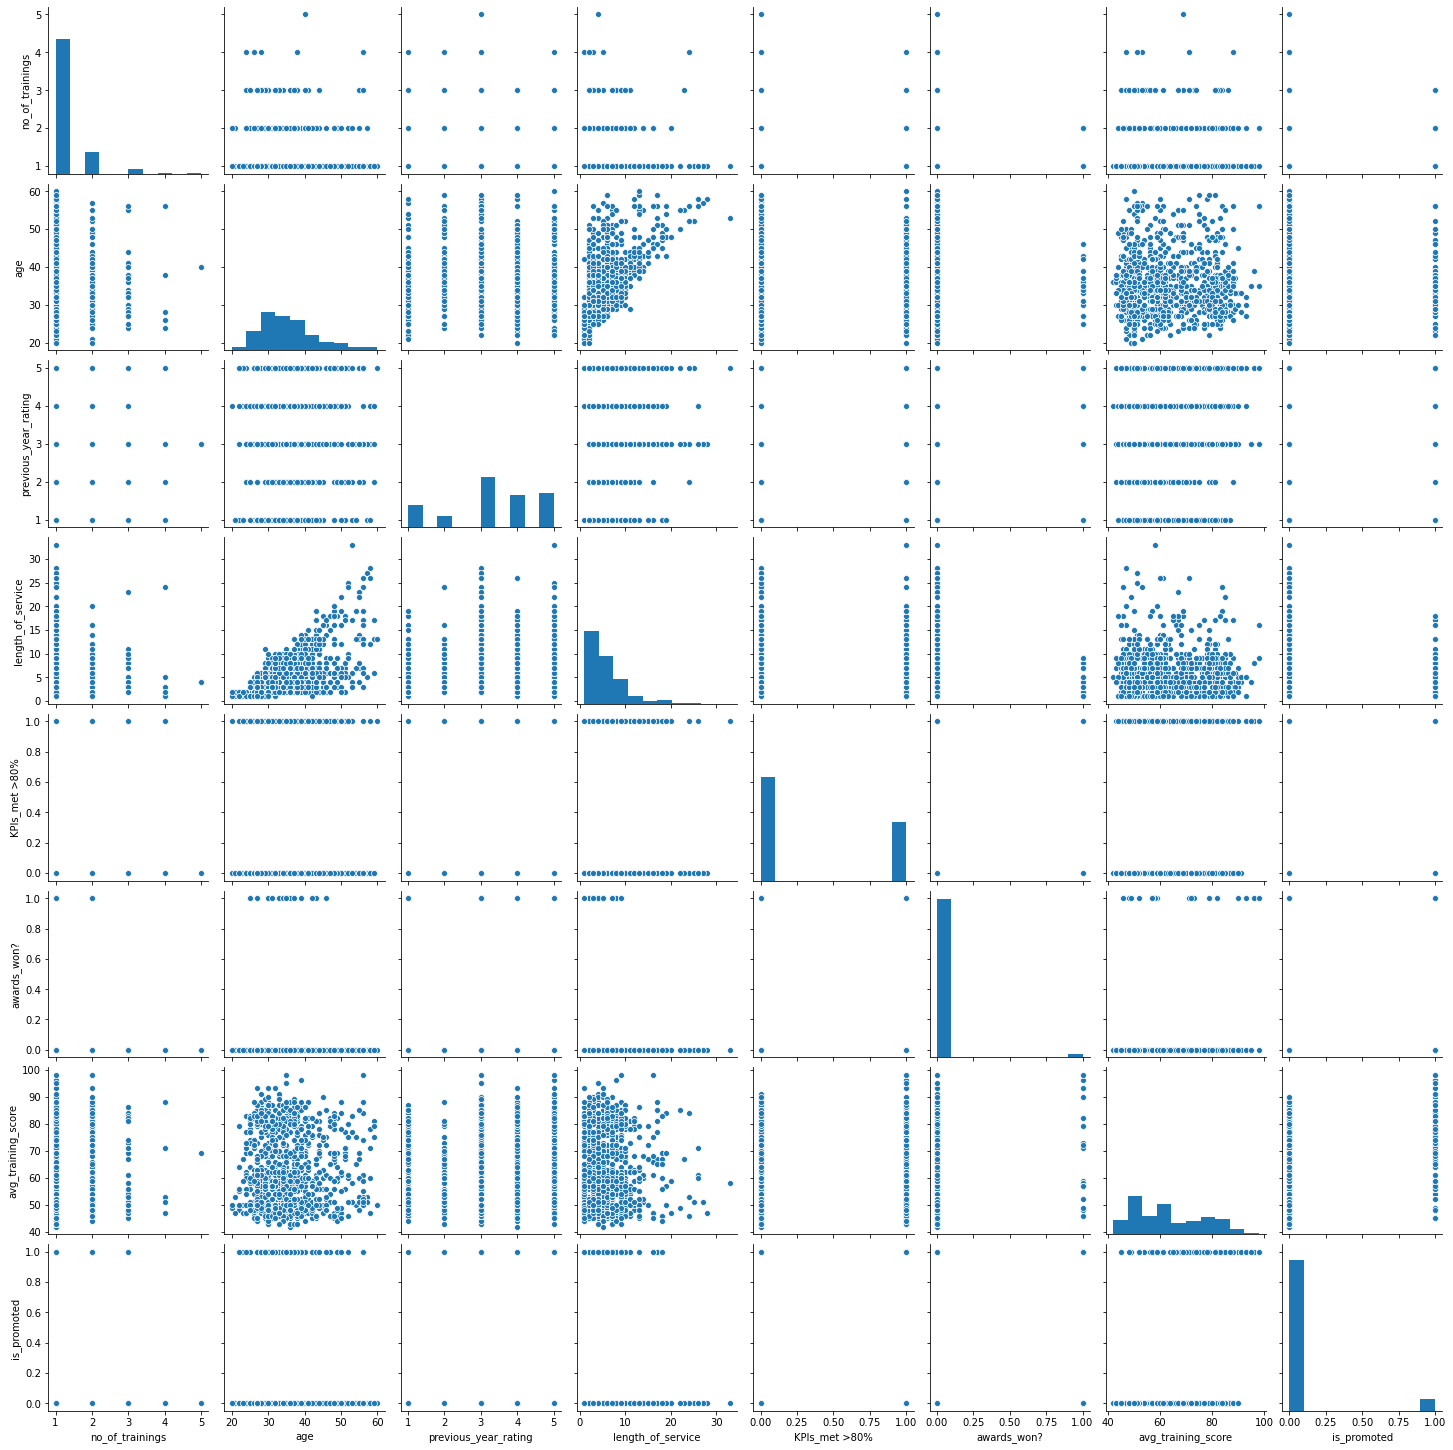

In [145]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data_raw.shape[0]), size=1000, replace=False)
sns.pairplot(data_raw.iloc[random_subset], diag_kind='hist')
pass

Небольшая линейная положительная зависимость наблюдается между признаками age и length_of_service. Также можем увидеть, что присутствуют выбросы, но их не так много. 


Построим гистограммы для визуального представления частоты некоторых признаков

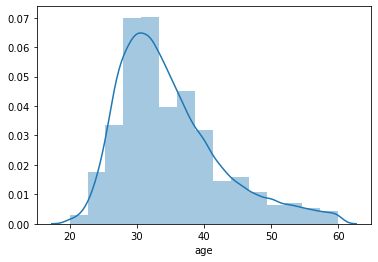

In [146]:
sns.distplot(data_raw['age'], bins = 15)
pass


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


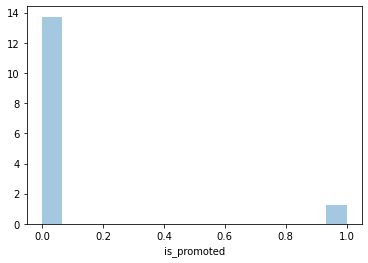

In [147]:
sns.distplot(data_raw['is_promoted'], bins = 15)
pass

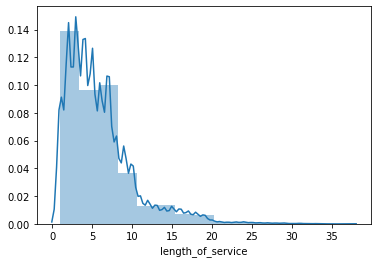

In [148]:
sns.distplot(data_raw['length_of_service'], bins = 15)
pass

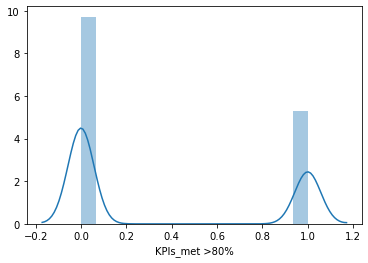

In [149]:
sns.distplot(data_raw['KPIs_met >80%'], bins = 15)
pass

## Обработка пропущенных значений

Выясним, сколько каждый столбец содержит пропущенных значений

In [150]:
data_raw.isna().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

2 столбца имеют пропущенные значения. Для количественного признака заполним пропущенные значения медианой, а для категориального - наиболее популярным значением в столбце

In [151]:
data_raw.fillna(data_raw.median(axis = 0), axis=0 , inplace=True)

In [152]:
for c in categorical_columns:
    data_raw[c] = data_raw[c].fillna(data_raw.describe(include = ['category'])[c]['top'])

In [153]:
data_raw.isna().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

Пропущенные значения заполнены.

In [154]:
data_raw.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


# Векторизация

Обработаем категориальные признаки. Для этого выедилим среди них бинарные и небинарные признаки. Бинарные признаки закодируем 0 и 1. А небинарные векторизуем, то есть вместо признака, принимающего n значений, добавим n признаков, 
которые будут принимать значения 0 или 1, в зависимости от значения исходного признака. 
Например, признак department принимает 9 различных значений. Если сотрудник работает в отделе 'Analytics', то новый признак 'Analytics' = 1,остальные 8 признаков принимают значение 0. 

In [155]:
data_statistics = data_raw.describe(include=['category'])
binary_columns    = [c for c in categorical_columns if data_statistics[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_statistics[c]['unique'] > 2]
binary_columns, nonbinary_columns


(['gender'], ['department', 'region', 'education', 'recruitment_channel'])

In [156]:
data_raw['gender'] = data_raw['gender'].cat.codes

In [157]:
department_dummies = pd.get_dummies(data_raw['department'])
region_dummies = pd.get_dummies(data_raw['region'])
education_dummies = pd.get_dummies(data_raw['education'])
recruitment_channel_dummies = pd.get_dummies(data_raw['recruitment_channel'])

In [158]:
department_dummies.head()

,Analytics,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,Technology
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1


In [159]:
region_dummies.head()

,region_1,region_10,region_11,region_12,region_13,region_14,region_15,region_16,region_17,region_18,...,region_31,region_32,region_33,region_34,region_4,region_5,region_6,region_7,region_8,region_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
education_dummies.head()

,Bachelor's,Below Secondary,Master's & above
0,0,0,1
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [161]:
recruitment_channel_dummies.head()

,other,referred,sourcing
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,1,0,0


Заменим признаки в таблице

In [162]:
data = pd.concat((data_raw, department_dummies, region_dummies, education_dummies, recruitment_channel_dummies), axis=1)
data = data.drop(['department', 'education', 'region', 'recruitment_channel'], axis=1)
data.head()

,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,Analytics,...,region_6,region_7,region_8,region_9,Bachelor's,Below Secondary,Master's & above,other,referred,sourcing
0,0,1,35,5.0,8,1,0,49,0,0,...,0,1,0,0,0,0,1,0,0,1
1,1,1,30,5.0,4,0,0,60,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,1,34,3.0,7,0,0,50,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,2,39,1.0,10,0,0,50,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,1,45,3.0,2,0,0,73,0,0,...,0,0,0,0,1,0,0,1,0,0


# Нормализация количественных признаков

Исключим влияние масштаба и диапазона данных на целевой признак, для этого нормализуем количественные признаки с помощью стандартизации.

In [163]:
data.describe()

,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,Analytics,...,region_6,region_7,region_8,region_9,Bachelor's,Below Secondary,Master's & above,other,referred,sourcing
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,...,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,0.702379,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170,0.097650,...,0.012589,0.088363,0.011951,0.007663,0.712998,0.014688,0.272314,0.555503,0.020836,0.423661
std,0.457216,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137,0.296844,...,0.111495,0.283825,0.108666,0.087204,0.452367,0.120300,0.445155,0.496914,0.142838,0.494142
min,0.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [164]:
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
numerical_columns.remove('is_promoted')
print(numerical_columns)
print(len(numerical_columns))

['gender', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'Analytics', 'Finance', 'HR', 'Legal', 'Operations', 'Procurement', 'R&D', 'Sales & Marketing', 'Technology', 'region_1', 'region_10', 'region_11', 'region_12', 'region_13', 'region_14', 'region_15', 'region_16', 'region_17', 'region_18', 'region_19', 'region_2', 'region_20', 'region_21', 'region_22', 'region_23', 'region_24', 'region_25', 'region_26', 'region_27', 'region_28', 'region_29', 'region_3', 'region_30', 'region_31', 'region_32', 'region_33', 'region_34', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9', "Bachelor's", 'Below Secondary', "Master's & above", 'other', 'referred', 'sourcing']
57


После нормализции сводка статистики по данным принимает вид:

In [165]:
data_norm = (data[numerical_columns] - data[numerical_columns].mean(axis = 0))/data[numerical_columns].std(axis = 0)
data_norm.describe()

,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,Analytics,Finance,...,region_6,region_7,region_8,region_9,Bachelor's,Below Secondary,Master's & above,other,referred,sourcing
count,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,...,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04
mean,-4.988347e-16,2.137098e-15,-3.489359e-16,8.051912e-16,4.175880e-16,1.677873e-15,1.902468e-16,1.004605e-16,1.337113e-15,1.016505e-15,...,-1.342731e-15,8.426173e-16,-1.591492e-15,-2.357409e-15,1.009548e-16,-2.464542e-15,-3.613208e-16,2.640017e-15,1.838396e-15,-8.217307e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.536209e+00,-4.152724e-01,-1.932583e+00,-1.897052e+00,-1.140775e+00,-7.369793e-01,-1.540163e-01,-1.823778e+00,-3.289611e-01,-2.202602e-01,...,-1.129145e-01,-3.113295e-01,-1.099779e-01,-8.787577e-02,-1.576151e+00,-1.220914e-01,-6.117293e-01,-1.117904e+00,-1.458745e-01,-8.573657e-01
25%,-1.536209e+00,-4.152724e-01,-7.576746e-01,-2.506492e-01,-6.718521e-01,-7.369793e-01,-1.540163e-01,-9.263504e-01,-3.289611e-01,-2.202602e-01,...,-1.129145e-01,-3.113295e-01,-1.099779e-01,-8.787577e-02,-1.576151e+00,-1.220914e-01,-6.117293e-01,-1.117904e+00,-1.458745e-01,-8.573657e-01
50%,6.509413e-01,-4.152724e-01,-2.354929e-01,-2.506492e-01,-2.029292e-01,-7.369793e-01,-1.540163e-01,-2.532801e-01,-3.289611e-01,-2.202602e-01,...,-1.129145e-01,-3.113295e-01,-1.099779e-01,-8.787577e-02,6.344454e-01,-1.220914e-01,-6.117293e-01,8.945145e-01,-1.458745e-01,-8.573657e-01
75%,6.509413e-01,-4.152724e-01,5.477796e-01,5.725520e-01,2.659936e-01,1.356866e+00,-1.540163e-01,9.432894e-01,-3.289611e-01,-2.202602e-01,...,-1.129145e-01,-3.113295e-01,-1.099779e-01,-8.787577e-02,6.344454e-01,-1.220914e-01,1.634680e+00,8.945145e-01,-1.458745e-01,1.166342e+00
max,6.509413e-01,1.435665e+01,3.289233e+00,1.395753e+00,7.299836e+00,1.356866e+00,6.492699e+00,2.663358e+00,3.039817e+00,4.540001e+00,...,8.856097e+00,3.211972e+00,9.092570e+00,1.137949e+01,6.344454e-01,8.190436e+00,1.634680e+00,8.945145e-01,6.855081e+00,1.166342e+00


# Обучающая и тестовая выборки

In [166]:
X = data_norm
y = data['is_promoted']
X = X.to_numpy()
y = y.to_numpy()

print(X.shape)
print(y.shape)

(54808, 57)
(54808,)


75% данных - обучающая выборка, 25% - тестовая выборка

In [167]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

41106 13702


# Классификатор ближайших соседей

Для обучения будем использовать k-Nearest Neighbourhood. Ниже приведена функция, обучающая модель и вычисляющая ошибки. Для начала проверим ошибки на выборках при k=5. 

In [168]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_train != y_train_pred)
err_test  = np.mean(y_test  != y_test_predict)
print(err_train, err_test)


0.07422274120566341 0.08560794044665013


Ошибка на обучающей выборке составляет около 7%, на тестовой - 8,5%. 

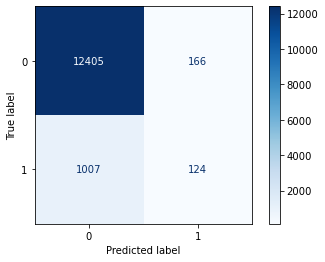

In [169]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
pass

Матрица рассогласования показывает, что на тестовой выборке из 13702 значений имеем 12405 true negative значений, 124 true positive значения, 1007 false negative и 166 false positive. Преобладает ошибка второго рода - ее вероятность = 0,89, вероятность ошибки 1 рода значительно меньше - 0,013. Скорее всего, это связано с тем, что целевой признак несбалансирован:  сотрудников, продвигающихся по службе(is_promoted=1) меньше, чем остающихся на той же должности(is_promoted=0). 

In [170]:

print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     12571
           1       0.43      0.11      0.17      1131

    accuracy                           0.91     13702
   macro avg       0.68      0.55      0.56     13702
weighted avg       0.88      0.91      0.89     13702



Попробуем сначала уменьшить параметр метода(число соседей), затем увеличить, посчитаем ошибки.

In [171]:
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_train != y_train_pred)
err_test  = np.mean(y_test  != y_test_predict)
print(err_train, err_test)

0.06310514280153749 0.09246825280980879


In [172]:
knn = KNeighborsClassifier(9)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_train != y_train_pred)
err_test  = np.mean(y_test  != y_test_predict)
print(err_train, err_test)

0.07964773998929596 0.08108305356882207


In [173]:
knn = KNeighborsClassifier(30)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_train != y_train_pred)
err_test  = np.mean(y_test  != y_test_predict)
print(err_train, err_test)

0.08312655086848635 0.08006130491898993


При уменьшении параметра n_neighbors ошибка на обучающей выборке уменьшилась, увеличившись при этом на тестовой выборке. При увеличении числа ближайших соседей  получаем противоположный результат: увеличение(незначительно) ошибки на обучающей выборке и уменьшение на тестовой выборке. 
Также при увеличении параметра ошибка на обучающей выборке стала превосходить ошибку на тестовой выборке. 
Подберем оптимальное значение параметра с помощью библиотеки gridSearch. Получим значение n_neighbors = 10.  

In [174]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 30]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb})
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.08388071840864375 10


Посчитаем ошибки при оптимальном значении параметра = 10. 

In [175]:
knn = KNeighborsClassifier(10)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_predict = knn.predict(X_test)
err_train = np.mean(y_train != y_train_pred)
err_test  = np.mean(y_test  != y_test_predict)
print(err_train, err_test)

0.08149661849851603 0.08035323310465625


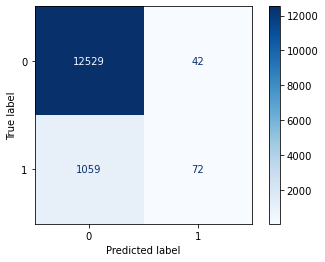

In [176]:
plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
pass

In [177]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12571
           1       0.63      0.06      0.12      1131

    accuracy                           0.92     13702
   macro avg       0.78      0.53      0.54     13702
weighted avg       0.90      0.92      0.89     13702



При оптимальном параметре ошибка на обучающей выборке улучшилась по сравнению с n_neighbours = 5 всего лишь на 0,5%. 

Эксперимент с параметром метода k-ближайших соседей показал, что изменение этого параметра в данной задаче не приводит к значительному изменению процента ошибки. 

# RF – случайный лес

Попробуем обучить модель другим методом - дерево решений, число деревьев выберем равное 100. 

In [179]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0002676008368607989 0.06371332652167566


По сравнению с предыдущим классификатором ошибка на обучающей выборке значительно уменьшилась, на тестовой - уменьшилась приблизительно на 2%. 

# SVC - метод опорных векторов

In [180]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.07084123972169513 0.07042767479200117


# Выводы

Была рассмотрена задача бинарной классификации. Исходные данные содержали около 55000 записей, которые были визуализированы и предобработаны. При использовании алгоритма K-ближайших соседей ошибка на тестовой выборке составила около 8%. Ошибка достаточно большая, но изменением параметра метода не удалось добиться значительного ее уменьшения. В качестве сравнения был использован алгоритм, использующий дерево решений, с ним ошибка составила около 6%, а также метод опорных векторов с ошибкой около 7%. При этом два последних алгоритма работают значительно быстрее метода K-ближайших соседей. 
Решение, которое, возможно, приведет к снижению ошибки - работа с несбалансированными признаками. 